In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.preprocessing import StandardScaler
import gc
nr = NearMiss(version=3,n_neighbors_ver3=3)
scaler=StandardScaler()

In [2]:
train=pd.read_csv(r'Datasets\filtered_data_sk.csv')
train.head()

,No_of_prevloans,Total_amount_due,Average_termdays,loannumber,good_bad_flag,age,bank_account_type_Current,loan_approval_time,loan_firstPayment_time
0,1.0,11500.0,15.0,2.0,1,50,0,1.018611,15.0
1,1.0,13000.0,30.0,2.0,0,38,0,1.018889,32.0
2,3.0,36000.0,20.0,4.0,1,37,0,1.001944,32.0
3,1.0,11500.0,15.0,2.0,1,32,0,1.018889,33.0
4,5.0,88000.0,30.0,6.0,1,33,0,1.018889,24.0


In [3]:
#Undersampling
y = train["good_bad_flag"]
x = train.drop(columns="good_bad_flag")
# resampling to remove imbalance
x,y =nr.fit_resample(x,y=y)
counter=Counter(y)
print(counter)

Counter({0: 711, 1: 711})


In [4]:
# Initialize random generator
rng = np.random.default_rng()

def imput_nan_rand(col, in_place=False):
    """Get a pd.Series with NaNs and impute missing values with random selection
    from the column's values range.
    """
    c = col if in_place else col.copy()
    # get indices of `-1` occurrences
    idxs = np.where(c == -1)[0]
    # initialize boolean mask
    m = np.ones(c.size, dtype=bool)
    # change boolean mask at indices
    m[idxs] = False
    # create column unique values range
    pool = np.unique(c[m]).astype(int)
    # assign random values from the pool at `-1` locations
    c[~m] = rng.choice(pool, size=idxs.size, shuffle=False)
    return c.astype(int)

In [5]:
from sklearn.linear_model import LogisticRegression

def logreg(features_labels_split, n_folds=5):

        # Differentiate assignments according to input (length=4 -> train_test_split)
    if len(features_labels_split) == 4:
        features, test_features, labels, test_labels = features_labels_split
    else:
        features, test_features = features_labels_split
        # Extract the labels for training
        labels = features['good_bad_flag']
        test_labels = None
         
    print('\nTraining Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = features.columns.tolist()
    
    # Impute missing values with Random Selection
    traintestX = [i.apply(imput_nan_rand) for i in (features, test_features)]
    #features,test_features=nr.fit_resample(features,test_features.ravel())
    
    # Normalization
    features, test_features = [scaler.fit_transform(i) for i in traintestX]

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Create the kfold object
    print("Creating KFold object")
    folds = KFold(n_splits=n_folds)
    
    # Lists for recording validation and training scores
    train_scores = []
    test_scores = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # save figure location
    print("\nStarting fold iterations")
    print(25*'-')
    fig, ax = plt.subplots(figsize=(8,5))
    # Iterate through folds
    for i, (train_idx, val_idx) in enumerate(folds.split(features)):
        # Training data for the fold
        fold_train_X, fold_train_y = features[train_idx], labels.iloc[train_idx]
        # Validation data for the fold
        fold_test_X, fold_test_y = features[val_idx], labels.iloc[val_idx]
        # Create the model
        model = LogisticRegression()
        # Train the model
        model.fit(fold_train_X, fold_train_y)
        # Make predictions using these importances
        test_predictions += model.predict_proba(test_features)[:, 1] / folds.n_splits
        # Record the out of fold predictions
        y_pred = model.predict(fold_test_X)
        y_proba = model.predict_proba(fold_test_X)
        out_of_fold[val_idx] = y_proba[:, 1]
        # Record train and ROC AUC scores
        train_scores.append(roc_auc_score(fold_train_y, model.predict_proba(fold_train_X)[:, 1]))
        test_scores.append(roc_auc_score(fold_test_y, y_proba[:, 1],  multi_class='ovr'))
        viz = RocCurveDisplay.from_predictions(
            fold_test_y,
            y_proba[:, 1],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        # Clean up memory
        del model, fold_train_X, fold_test_X, fold_train_y, fold_test_y
        gc.collect()
    
    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Logistic Regression - Receiver operating characteristic (ROC)",
    )
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Make the feature importance dataframe
    attrib_imp = pd.DataFrame({'attribute': feature_names,
                               'importance': feature_importance_values})
    
    # Overall validation score
    test_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    test_scores.append(test_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'test': test_scores})
    pred_df = pd.DataFrame({'prediction' :y_pred})
    
    return attrib_imp, metrics,pred_df



Training Data Shape:  (1066, 8)
Testing Data Shape:  (356, 8)
Creating KFold object

Starting fold iterations
-------------------------


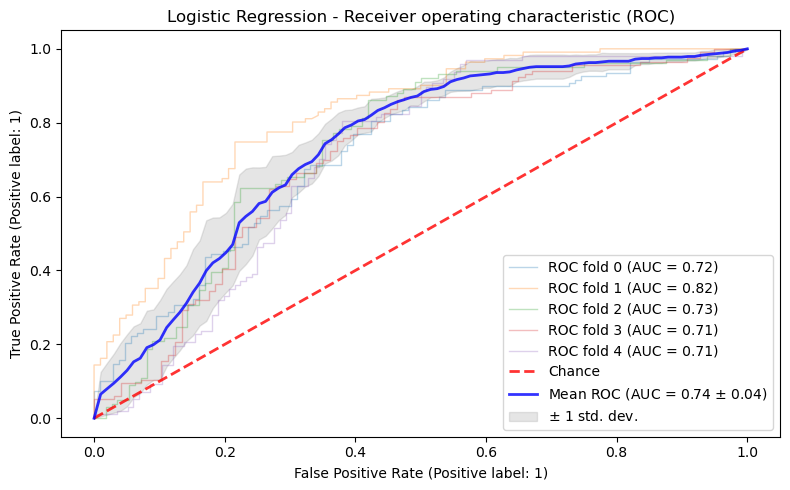

In [6]:
attrib_imp_i, metrics_i,pred = logreg(train_test_split(x, y, stratify=y, test_size=.25))

In [7]:
from sklearn.svm import SVC

# SVM

def svm_model(features_labels_split, n_folds=5):
    """Train and test a light SVC model using
    cross validation with KFold splits. 

    Ref: https://www.kaggle.com/code/prashant111/svm-classifier-tutorial
    """
    
    # Differentiate assignments according to input (length=4 -> train_test_split)
    if len(features_labels_split) == 4:
        features, test_features, labels, test_labels = features_labels_split
    else:
        features, test_features = features_labels_split
        # Extract the labels for training
        labels = features['RGM30_flag']

        
    print('\nTraining Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = features.columns.tolist()
    
    # Impute missing values with Random Selection
    traintestX = [i.apply(imput_nan_rand) for i in (features, test_features)]
    # Normalization
    features, test_features = [scaler.fit_transform(i) for i in traintestX]

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Create the kfold object
    print("Creating KFold object")
    folds = KFold(n_splits=n_folds)
    
    # Lists for recording validation and training scores
    train_scores = []
    test_scores = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # save figure location
    #lgb_roc_plt_file = f'{colab_dir if IN_COLAB else remote_dir}lgb_roc_{ts}_{lgbm_ts}.png'
    print("\nStarting fold iterations")
    print(25*'-')
    fig, ax = plt.subplots(figsize=(8,5))
    # Iterate through folds
    for i, (train_idx, val_idx) in enumerate(folds.split(features)):
        # Training data for the fold
        fold_train_X, fold_train_y = features[train_idx], labels.iloc[train_idx]
        # Validation data for the fold
        fold_test_X, fold_test_y = features[val_idx], labels.iloc[val_idx]
        # Create the model
        svc=SVC(kernel='linear',probability=True) 
        # Train the model
        svc.fit(fold_train_X, fold_train_y)
        # Make predictions using these importances
        test_predictions += svc.predict_proba(test_features)[:, 1] / folds.n_splits
        # Record the out of fold predictions
        y_proba = svc.predict_proba(fold_test_X)
        out_of_fold[val_idx] = y_proba[:, 1]
        # Record the best score
        train_scores.append(roc_auc_score(fold_train_y, svc.predict_proba(fold_train_X)[:, 1]))
        test_scores.append(roc_auc_score(fold_test_y, y_proba[:, 1],  multi_class='ovr'))
        viz = RocCurveDisplay.from_predictions(
            fold_test_y,
            y_proba[:, 1],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        # Clean up memory
        del svc, fold_train_X, fold_test_X, fold_train_y, fold_test_y
        gc.collect()

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="SVC - Receiver operating characteristic (ROC)",
    )
    ax.legend(loc="lower right")
    plt.tight_layout()
    #plt.savefig('scoring_output/LightGBM.png', transparent=False, bbox_inches="tight")
    plt.show()
    plt.close()

    print(25*'-')
    print("Creating output")    

    
    # Make the feature importance dataframe
    attrib_imp = pd.DataFrame({'attribute': feature_names,
                               'importance': feature_importance_values})
    
    # Overall validation score
    test_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    test_scores.append(test_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'test': test_scores}) 
    
    return attrib_imp, metrics


Training Data Shape:  (1066, 8)
Testing Data Shape:  (356, 8)
Creating KFold object

Starting fold iterations
-------------------------


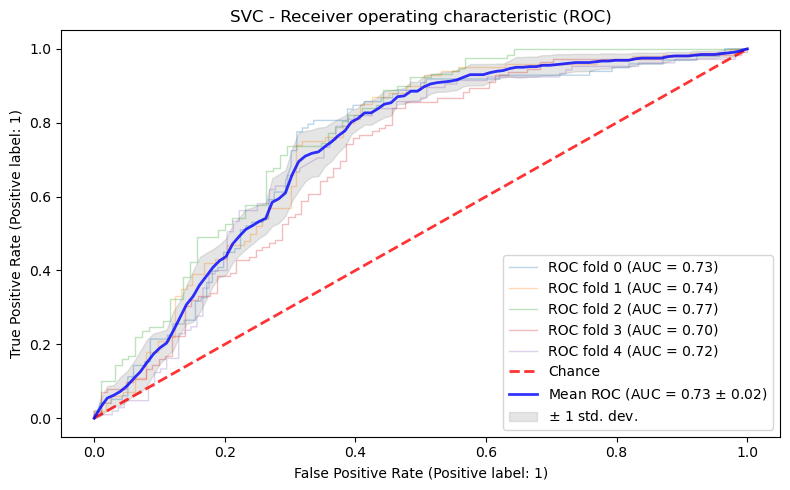

-------------------------
Creating output


In [8]:
attrib_imp_i, metrics_i = svm_model(train_test_split(x, y, stratify=y, test_size=.25))